In [1]:
# import exportnb
# exportnb.export_notebooks(['./210618 - Functions_for_import.ipynb'])
import setup

In [2]:
import importlib
importlib.reload(setup)

<module 'setup' from '/home/guillermo/Nextcloud/projects/Distributed_Q_gates_clean/Codes/setup.py'>

In [3]:
import numpy as np
import os.path
from numpy import pi, floor, sqrt
from math import pi as π
import scipy.sparse as sp
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from joblib import delayed, Parallel, parallel_backend

In [4]:
styles = ['science']
prefix = '../stylelib/'
sufix = '.mplstyle'
for i in range(len(styles)):
    styles[i] = prefix + styles[i] + sufix
plt.style.use(styles)
plt.rcParams.update({'font.size': 20})

## Function that implements evolution

In [11]:
from numpy import pi as π

def Trotter_solver_dynamics(time,v0,control,g1=None,g2=None):
    vt = [v0]
    last_t = time[0]
    for t in time[1:]:
        dt = t - last_t
        v0 = scipy.sparse.linalg.expm_multiply((-1j*dt) * control.Hamiltonian(g1=g1(t), g2=g2(t)), v0)
        vt.append(v0)
        last_t = t
    return np.array(vt).T

## Shape of the controls

In [12]:
def sech(x):
    return 1/np.cosh(x)

def sech(x):
    return np.tanh(x)/np.sinh(x)
    
def gt(t, σ, κ):
    if σ == 0.5*κ:
        return σ / np.cosh(σ*t)
    th = np.tanh(t*σ)
    ex = np.exp(-2*t*σ)
    return (κ - 2*σ*th)/np.sqrt(2*(κ*(1+ex)-2*σ)/σ)

## State transfer

We define a state transfer protocol with two pulses centered at $\pm t_{delay}=\pm t_{prop}/2.$ Each pulse lasts $24/\kappa$ so that the sech profile is properly dampened at the beginning and at the end. We only need $\sim 3000$ time steps, because the number of time steps is determined by how fast the Hamiltonian changes --- we can do arbitrarily large exponentials, Python takes care of that; our only error is the fact that we do piecewise constant Hamiltonian simulations.

In [8]:
import scipy.interpolate

def state_transfer(lamb_shift=None, δ1=2*π*8.40701933547913, δ2=2*π*8.40701933547913,
                   ω1=2*π*8.40701933547913, ω2=2*π*8.40701933547913,
                    kappa=2*π*20e-3, κ1=None, κ2=None, σ=0.5,
                   Tfp=10, Nt=3000, lwv=30, Nm=2101,
                   quiet=False, filename=None):
    if κ1 is None:
        κ1 = kappa
    if κ2 is None:
        κ2 = κ1
    if lamb_shift is None:
        lamb_shift = interp_lamb(κ1, lwv)
        
  
    
    control = setup.Exp2QB2Cavities(δLamb = lamb_shift, δ1 = δ1, δ2 = δ2, ω1 = ω1, ω2 = ω2, g1=0, g2=0, κ1=κ1, κ2=κ2, l=lwv, mmax=Nm)
    
    ## solve dynamics
    tdelay = 1*control.tprop #separation between protocol g_1(t) and g_2(t) /time reversed. 
    σ *= κ1
    duration = tdelay + 2 * (Tfp/σ)
    time = np.linspace(-duration/2, duration/2, Nt)
   
    def g1t(t):
        return gt(t + tdelay/2, σ,  κ1)

    def g2t(t):
        return gt(tdelay/2 - t, σ,  κ2)

    #Control initial/final values:
    print(f'Initial value of the control g_1(-tf)= (2π)*{g1t(time[0])/2/π*1e3}MHz')
    print('κ1= (2π)',κ1/2/π*1e3,'MHz')    
    print(f'Total time ={duration/control.tprop}*Propagation_time')

    vt = Trotter_solver_dynamics(time, control.qubit_excited(which=0), control, g1=g1t, g2=g2t)
    P = np.abs(vt)**2
    ## Showing results:
    Pwaveguide = np.sum(P[4:,:],0)
    print(f'|q_1(tf)|^2 = {P[0,-1]}\n'
          f'|c_1(tf)|^2 = {P[2,-1]}\n'
          f'|wv(tf)|^2  = {Pwaveguide[-1]} (max = {max(Pwaveguide)})\n'
          f'|c_2(tf)|^2 = {P[3,-1]}\n'
          f'|q_2(tf)|^2 = {P[1,-1]}\n'
          f' 1-F        = {1-P[1,-1]}')
    if not quiet:
        fig, (ax, axc) = plt.subplots(nrows=2, figsize=(8,6), sharex=True)
        ax.plot(time*κ1, P[0,:], label='qubit 1')
        ax.plot(time*κ1, P[1,:], label='qubit 2')
        ax.plot(time*κ1, P[2,:], '--', label='cavity 1')
        ax.plot(time*κ1, P[3,:], '--', label='cavity 2')
        ax.plot(time*κ1, Pwaveguide, '-.', label='waveguide')
        #ax.set_xlabel(r'$t\κ1$')
        ax.legend(fontsize=16)
        ax.set_title(f'$l={lwv}\,m,\,'
                     r'\omega=2\pi\times'
                     f'{control.ω1/(2*π)}'
                     r'\,\mathrm{GHz},\,\kappa_1=2\pi\times'
                     f'{np.round(κ1/(2e-3*π))}'
                     r'\,\mathrm{MHz},\,\sigma/\kappa_1='
                     f'{np.round(σ/κ1,3)}$', fontsize=16)
        axc.plot(time*κ1, g1t(time)/κ1, label=r'$g_1(t)/\kappa_1$')
        axc.plot(time*κ1, g2t(time)/κ2, label=r'$g_2(t)/\kappa_2$')
        axc.set_xlabel(r'$t\kappa_1$')
        axc.set_ylabel(r'$g_i(t)/\kappa_i$')
        axc.legend(fontsize=16)
        fig.tight_layout()
        plt.show()
        if filename:
            fig.savefig(filename)
    
    cumulative_time_qubit_1 = np.trapz(P[0,:], x = time[:])
    cumulative_time_qubit_2 = np.trapz(P[1,:], x = time[:])
    
    k = cumulative_time_qubit_1 + cumulative_time_qubit_2
    
    timeres = time/control.tprop
    q1end = P[0,-1]
    q2end = P[1,-1]
    return q2end, q1end, control.ωrelevant, k

The state transfer protocol also works in a limit in which the photons do not fit into the waveguide:

With our new controls can vary the width of the pulse, so that it is no longer $\kappa/2$, and still get good transfer

## Systematic studies

We explore three lengths, $l=30$m, $l=5$m and $l=1$m, for a variety of $\kappa$, and also in one instance for pulses with enlarged duration $\sigma=\kappa/4.$ We also explore different values of $\eta$ and detunings with respect to one of the WG modes. Unless otherwise specified. $\eta = 1$, and resonant condition.

In [9]:
# Execute this line to remove the precomputed files
# !del state_transfer_*.npy

In [10]:
all_kappas = 2*π*np.logspace(0.0, 2.0, 36)*1e-3

In [15]:
# 1meter. 

if os.path.exists(' ../Data/P_transfer_1m_71modes.npy'):
    P_transfer_1m_71modes = np.load('../Data/P_transfer_1m_71modes.npy', allow_pickle = True)
    
else:  
    with parallel_backend('loky', n_jobs=36):
        P_transfer_1m_71modes = Parallel()(delayed(state_transfer)(δ1=2*π*8.492099722936853, δ2=2*π*8.492099722936853,
                   ω1=2*π*8.492099722936853, ω2=2*π*8.492099722936853, lamb_shift=-0.01732777777777778*κ, kappa=κ, Tfp=15, lwv=1, Nm=71, quiet=True)
                     for κ in all_kappas)
        P_transfer_1m_71modes = np.array(P_transfer_1m_71modes, dtype = object)
    np.save('../Data/P_transfer_1m_71modes.npy', P_transfer_1m_71modes)

In [16]:
# 5meters. Off-resonance.

if os.path.exists(' ../Data/P_transfer_5m_offresonance.npy'):
    P_transfer_5m_offresonance = np.load('../Data/P_transfer_5m_offresonance.npy', allow_pickle = True) 
    
else:
    with parallel_backend('loky', n_jobs=36):
        P_transfer_5m_offresonance = Parallel()(delayed(state_transfer)(δ1=2*π*8.407027464805756, δ2=2*π*8.407027464805756,
                   ω1=2*π*8.407027464805756, ω2=2*π*8.407027464805756,lamb_shift=-0.012187088888888885*κ, kappa=κ, lwv=5, Nm=351, quiet=True)
                     for κ in all_kappas)
        P_transfer_5m_offresonance =  np.array(P_transfer_5m_offresonance, dtype = object)                       
    np.save('../Data/P_transfer_5m_offresonance.npy', P_transfer_5m_offresonance)

In [12]:
#5 meters.

if os.path.exists(' ../Data/P_transfer_5m.npy'):
    P_transfer_5m = np.load('../Data/P_transfer_5m.npy', allow_pickle = True)
    
else:
    with parallel_backend('loky', n_jobs=36):
        P_transfer_5m = Parallel()(delayed(state_transfer)(δ1=2*π*8.416408398466828, δ2=2*π*8.416408398466828,
                   ω1=2*π*8.416408398466828, ω2=2*π*8.416408398466828, lamb_shift=-0.012187088888888885*κ, kappa=κ, Tfp=15, lwv=5, Nm=351, quiet=True)
                     for κ in all_kappas)
        P_transfer_5m =  np.array(P_transfer_5m, dtype = object)
    np.save('../Data/P_transfer_5m.npy', P_transfer_5m )

In [18]:
# 30 meters
all_kappas_30 = 2*π*np.logspace(0.0, 2.0, 21)*1e-3

if os.path.exists(' ../Data/P_transfer_30m.npy'):
    P_transfer_30m = np.load('../Data/P_transfer_30m.npy', allow_pickle = True)
    
else:
#     with parallel_backend('loky', n_jobs=36):
#         P_transfer_30m = Parallel()(delayed(state_transfer)(lamb_shift=-0.011618999999999999*κ, kappa=κ, Tfp=20, quiet=True)
#                          for κ in all_kappas_30)
       
        P_transfer_30m = [state_transfer(lamb_shift=-0.011618999999999999*κ, kappa=κ, Tfp=20, quiet=True)
                         for κ in all_kappas_30]
        

        P_transfer_30m = np.array(P_transfer_30m, dtype = object)
        np.save('../Data/P_transfer_30m.npy', P_transfer_30m)

Initial value of the control g_1(-tf)= (2π)*2.061153622438558e-09MHz
κ1= (2π) 1.0 MHz
Total time =80.62791502307644*Propagation_time
|q_1(tf)|^2 = 8.260195877172515e-11
|c_1(tf)|^2 = 6.786040560144677e-10
|wv(tf)|^2  = 6.187918825139774e-10 (max = 0.24599434197158082)
|c_2(tf)|^2 = 7.938328233277334e-10
|q_2(tf)|^2 = 0.9999999978251355
 1-F        = 2.1748645107066977e-09
Initial value of the control g_1(-tf)= (2π)*2.5948386728995007e-09MHz
κ1= (2π) 1.2589254117941673 MHz
Total time =64.25070117505541*Propagation_time
|q_1(tf)|^2 = 1.3927175501192147e-10
|c_1(tf)|^2 = 2.815968998229364e-10
|wv(tf)|^2  = 1.1036138249182773e-09 (max = 0.30604300188491323)
|c_2(tf)|^2 = 1.8626880171925632e-09
|q_2(tf)|^2 = 0.9999999966153976
 1-F        = 3.38460237614413e-09
Initial value of the control g_1(-tf)= (2π)*3.266708344819447e-09MHz
κ1= (2π) 1.5848931924611138 MHz
Total time =51.24181780945479*Propagation_time
|q_1(tf)|^2 = 2.0870078099877003e-10
|c_1(tf)|^2 = 2.9686710283521897e-09
|wv(tf)|^2 

In [19]:
# 30 meters. η = 4, which halves the coupling.

if os.path.exists(' ../Data/P_transfer_30m_quarter.npy'):
    P_transfer_30m_quarter = np.load('../Data/P_transfer_30m_quarter.npy', allow_pickle = True)
    
else:
    # with parallel_backend('loky', n_jobs=36):
    #     all_kappas_30 = 2*π*np.logspace(0.0, 2.0, 5)*1e-3
    #     P_transfer_30m_quarter = Parallel()(delayed(state_transfer)(lamb_shift=-0.011618999999999999*κ, kappa=κ, Tfp = 15, quiet=True, σ=0.25)
    #                      for κ in all_kappas_30)

    P_transfer_30m_quarter = [state_transfer(lamb_shift=-0.011618999999999999*κ, kappa=κ, Nt=5000, Tfp = 15, quiet=True, σ=0.125)
                     for κ in all_kappas_30]
    P_transfer_30m_quarter = np.array(P_transfer_30m_quarter, dtype = object)
    np.save('../Data/P_transfer_30m_quarter.npy', P_transfer_30m_quarter)

Initial value of the control g_1(-tf)= (2π)*9.55944751568138e-08MHz
κ1= (2π) 1.0 MHz
Total time =239.88374506922932*Propagation_time
|q_1(tf)|^2 = 9.499121336064398e-11
|c_1(tf)|^2 = 8.126750201373248e-11
|wv(tf)|^2  = 4.78085776191513e-11 (max = 0.06270368797277814)
|c_2(tf)|^2 = 8.912399232944718e-11
|q_2(tf)|^2 = 0.9999999996945306
 1-F        = 3.0546942753062467e-10
Initial value of the control g_1(-tf)= (2π)*1.2034631400203885e-07MHz
κ1= (2π) 1.2589254117941673 MHz
Total time =190.75210352516623*Propagation_time
|q_1(tf)|^2 = 3.294949931534497e-10
|c_1(tf)|^2 = 4.933425015394587e-11
|wv(tf)|^2  = 4.908026910331526e-11 (max = 0.07887890678024177)
|c_2(tf)|^2 = 5.5351938368267674e-11
|q_2(tf)|^2 = 0.9999999995147391
 1-F        = 4.852609425398668e-10
Initial value of the control g_1(-tf)= (2π)*1.5150703291292697e-07MHz
κ1= (2π) 1.5848931924611138 MHz
Total time =151.72545342836435*Propagation_time
|q_1(tf)|^2 = 6.691221830211315e-10
|c_1(tf)|^2 = 1.0141367962177968e-11
|wv(tf)|^2 

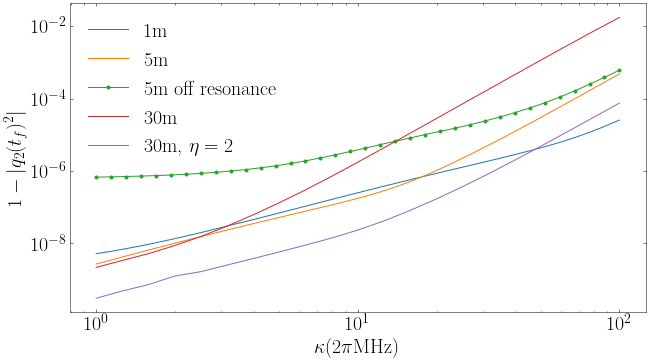

In [21]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(9,5), sharey = True, constrained_layout=True)

ax1.loglog(all_kappas/(2e-3*π), 1-P_transfer_1m_71modes[:,0], label = '1m')
ax1.loglog(all_kappas/(2e-3*π), 1-P_transfer_5m[:,0], label = '5m')
ax1.loglog(all_kappas/(2e-3*π), 1-P_transfer_5m_offresonance[:,0],'.-', label = '5m off resonance')
ax1.loglog( all_kappas_30/(2e-3*π), 1-P_transfer_30m[:,0], label = '30m')
ax1.loglog(all_kappas_30/(2e-3*π), 1-P_transfer_30m_quarter[:,0], label = '30m, $\\eta=2$')

# ax1.loglog(all_kappas_30/(2e-3*π), 1-P_transfer_30m_half[:,0], label = '30m, $\\eta=2$')




ax1.set_ylabel('$$1- |q_2(t_f)^2|$$')
ax1.set_xlabel(' $ \kappa (2\pi \\text{MHz}) $ ')

ax1.legend()

plt.show()

## Control bandwidth

In response to the referee criticism that no discussion was made regarding the bandwith of coupling, we are conducting a study here in wich we do a Fourier transform of the control, aply a filter in frequency space as in https://journals.aps.org/prapplied/pdf/10.1103/PhysRevApplied.14.044035, and transform back to time.

After this we check how much the pulse is been distorted.

We are going to use a filter function of the form $$\mathcal{H(\omega)} = \frac{\omega_c}{\omega_c - i \omega}. $$

In [36]:
import scipy.fft as Fourier

def gt(t, σ):

    f = np.exp(-np.abs(σ*t))
    γ4 = 2*f/(1 + f*f)
        
    return σ*γ4

def gt1(t, σ, κ):
    if σ == 0.5*κ:
        return σ / np.cosh(σ*t)
    th = np.tanh(t*σ)
    ex = np.exp(-2*t*σ)
    return (κ - 2*σ*th)/np.sqrt(2*(κ*(1+ex)-2*σ)/σ)

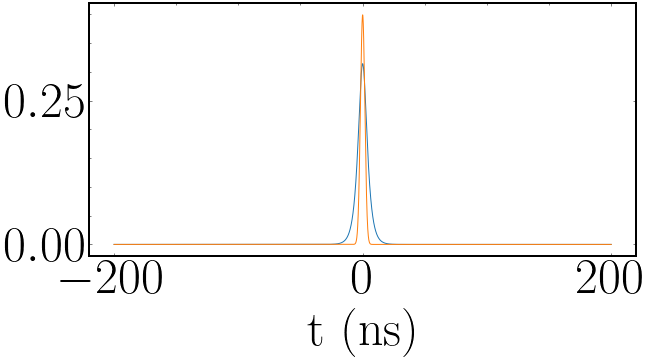

In [37]:
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(9,5), sharey = True, constrained_layout=True)

t = np.linspace(-200,200, 10000)
κ = 2*π*100*1e-3 
σ = κ/2
Gaussian = (lambda σ, t: 1/σ**0.5*np.exp(-t**2/σ))

control = gt(t, σ)
ax.plot(t,control)
ax.plot(t,Gaussian(σ*20,t))

ax.set_xlabel('t (ns)')
# ax.set_ylim(1e-15, 1)

plt.show()


In [38]:
def Compute_distortion(κ = 2*π*100*1e-3, tmax= 500, Npoints = 1000, ω_c = 400*1e-3, norm = 'ortho', σ = 1 ):
    
    t = np.linspace(-np.int(tmax/2), np.int(tmax/2), Npoints)
    # σ = κ/2

    control = gt1(t, σ*κ/2, κ)
    
    ''' Computes the Fourier transform of the control '''
    Transform = Fourier.fft(control, norm = norm)  # We choose to normalize it
    freqs = Fourier.fftfreq(len(t), d = t[1]-t[0])  # We construct the frequancy vector form the time data.
    
    ''' Define the filter function'''
    ω = freqs#*2*π  # I believe this 2*π is correct given how we have defined the cut-off freq. CHECK!
    Filter = ω_c / (ω_c - 1j*ω)  # Filter function as in the article
    
    Transform_filter = Transform*Filter  # multiply the Fourier transform by the filter to see what happens.
    
    '''Compute the inverse Fourier transform'''
    control_back =  Fourier.ifft(Transform, norm = norm)

    control_filtered_back = Fourier.ifft(Transform_filter, norm = norm)
    
    ''' We compute the distortion by means of the formula bellow '''
    g_gtilde = control*np.abs(control_filtered_back)
    g_g = control*control
    Distortion = (1 - np.trapz( g_gtilde ,x=t) / np.trapz( g_g , x=t))
    
    return Transform, Transform_filter, freqs, control_back, control_filtered_back, t, Distortion 



9.997000199999942

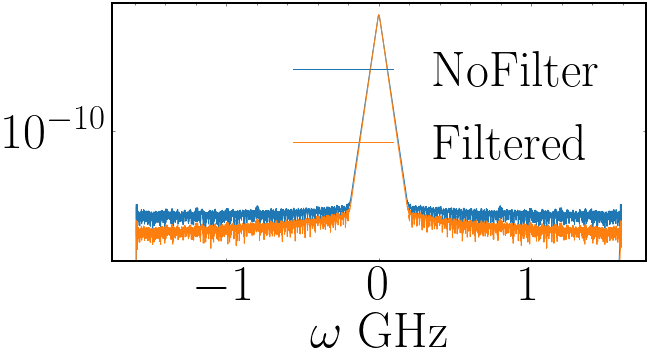

In [39]:
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(9,5), sharey = True, constrained_layout=True)


Npoints = 10000
κ = 2*π*100*1e-3
ax.semilogy(Compute_distortion(κ=κ, Npoints=Npoints)[2]/2/π, np.abs(Compute_distortion(κ=κ, Npoints=Npoints)[0]), label = 'NoFilter')
ax.semilogy(Compute_distortion(κ=κ,Npoints=Npoints)[2]/2/π, np.abs(Compute_distortion(κ=κ, Npoints=Npoints)[1]), label = 'Filtered')

ax.set_xlabel( '$\omega$ GHz' )


ax.legend()
np.max(Compute_distortion(κ=κ,Npoints=Npoints)[2])

In [40]:
# 1 - np.trapz(control*np.abs(control_back), x=t)/np.trapz(control*control, x=t)

We compute the distortion as $$ \text{Dist} = 1 - \frac{\int g \tilde{g} \; dt}{\int g^2  \; dt} $$

In [63]:
all_cutoff_freqs = np.linspace(100, 1000, 50)*1e-3
Distortion_50_eta_2 = [Compute_distortion(κ = 2*π*50*1e-3, tmax= 500, Npoints=10000, ω_c = ω_c, σ = 0.5 )[-1] for ω_c in all_cutoff_freqs]
Distortion_50 = [Compute_distortion(κ = 2*π*50*1e-3, tmax= 500, Npoints=10000, ω_c = ω_c)[-1] for ω_c in all_cutoff_freqs]
Distortion_100 = [Compute_distortion(κ = 2*π*100*1e-3, tmax= 500, Npoints=10000, ω_c = ω_c)[-1] for ω_c in all_cutoff_freqs]

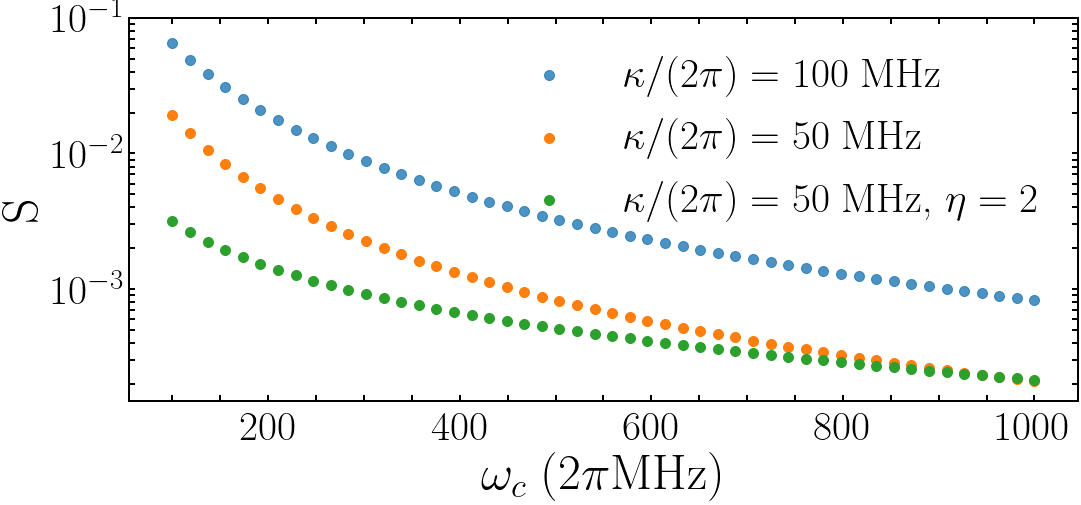

In [87]:
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(15,7), sharey = True, constrained_layout=True)
plt.rcParams.update({'font.size': 50})
plt.rcParams['axes.linewidth'] = 2

ax.scatter(all_cutoff_freqs*1e3, Distortion_100, s=100,alpha = 0.8, label = '$\kappa/(2\pi) =  100 \; $MHz')
ax.scatter(all_cutoff_freqs*1e3, Distortion_50, s=100, label = '$\kappa/(2\pi) =  50 \; $MHz')
ax.scatter(all_cutoff_freqs*1e3, Distortion_50_eta_2, s=100, label = '$\kappa/(2\pi) =  50 \; $MHz, $\\eta = 2$')

ax.set_ylabel('S')
ax.set_xlabel('$$ \\omega_c \; (2\pi\\text{MHz)} $$ ')
# ax.set_xlabel('$$ \\omega_c / \\kappa $$ ')

ax.legend(fontsize = 'small')
ax.set_ylim(1.5e-4, 1e-1)

# ax.xaxis.set_tick_params(labelsize=37)
ax.yaxis.set_tick_params(labelsize=37)
ax.yaxis.set_tick_params(labelsize=37)
ax.tick_params(labelcolor='black', labelsize='small', width=2, length =6)
ax.tick_params(which='minor', color='black',  width=2, length=6)
ax.xaxis.set_tick_params(pad=10)
ax.tick_params(labelcolor='black', labelsize='small', width=2, length =6) 
ax.semilogy()

plt.show()
fig.savefig('../Figures/fig7.svg')
fig.savefig('../Figures/fig7.pdf')

In [ ]:
np.max(Compute_distortion(κ = 2*π*100*1e-3, Npoints=10000)[2]), 2*π*400*1e-3

(9.997000199999942, 2.5132741228718345)

## FFT example

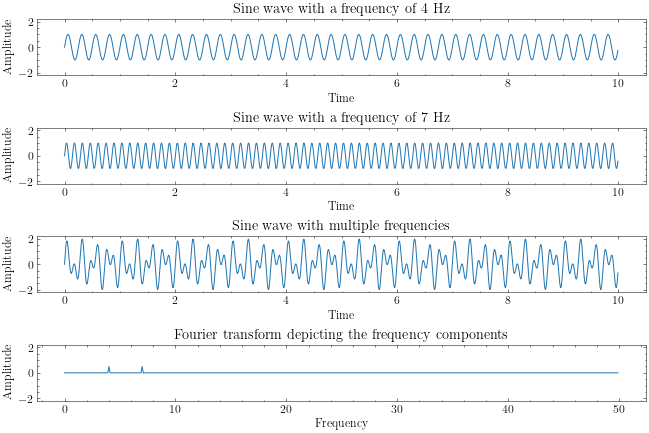

In [13]:
# Python example - Fourier transform using numpy.fft method

import numpy as np
import matplotlib.pyplot as plotter
plt.rcParams.update({'font.size': 12})
 
# How many time points are needed i,e., Sampling Frequency

samplingFrequency   = 100;

# At what intervals time points are sampled

samplingInterval       = 1 / samplingFrequency;

# Begin time period of the signals

beginTime           = 0;

# End time period of the signals

endTime             = 10; 

# Frequency of the signals

signal1Frequency     = 4;

signal2Frequency     = 7;

 
    # Time points

time        = np.arange(beginTime, endTime, samplingInterval);

 

# Create two sine waves

amplitude1 = np.sin(2*np.pi*signal1Frequency*time)
amplitude2 = np.sin(2*np.pi*signal2Frequency*time)

 

# Create subplot

figure, axis = plt.subplots(nrows=4, ncols=1, figsize=(9,6), sharey = True, constrained_layout=True)

 

# Time domain representation for sine wave 1

axis[0].set_title('Sine wave with a frequency of 4 Hz')
axis[0].plot(time, amplitude1)
axis[0].set_xlabel('Time')
axis[0].set_ylabel('Amplitude')


# Time domain representation for sine wave 2

axis[1].set_title('Sine wave with a frequency of 7 Hz')
axis[1].plot(time, amplitude2)
axis[1].set_xlabel('Time')
axis[1].set_ylabel('Amplitude')

 

# Add the sine waves

amplitude = amplitude1 + amplitude2

 
# Time domain representation of the resultant sine wave

axis[2].set_title('Sine wave with multiple frequencies')
axis[2].plot(time, amplitude)
axis[2].set_xlabel('Time')
axis[2].set_ylabel('Amplitude')


# Frequency domain representation

fourierTransform = np.fft.fft(amplitude)/len(amplitude)           # Normalize amplitude

fourierTransform = fourierTransform[range(int(len(amplitude)/2))] # Exclude sampling frequency

 

tpCount     = len(amplitude)

values      = np.arange(int(tpCount/2))

timePeriod  = tpCount/samplingFrequency

frequencies = values/timePeriod


# Frequency domain representation

axis[3].set_title('Fourier transform depicting the frequency components')
axis[3].plot(frequencies, abs(fourierTransform))
axis[3].set_xlabel('Frequency')
axis[3].set_ylabel('Amplitude')

plotter.show()